# Titanic Analysis Practice

The primary targets of this practice:
1. Take this excercise as a preparation for kaggle competitions
2. Hands-on experience to data analysis, cleaning and modeling
3. Review visual analytic skills (matplotlib and seaborn)
4. Use interactive ploting module: plotly (taking a Udemy course now)

Let's do it!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# filter warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

%matplotlib inline
sns.set_style('darkgrid')

## Define the problem

The problem is to predict the survivals in titanic.

## Gather the Data

As the data is already given in the competition, all we need to do is to read them.

In [2]:
gender_submission = pd.read_csv('titanic/gender_submission.csv')
test_df = pd.read_csv('titanic/test.csv')
train_df = pd.read_csv('titanic/train.csv')

## Prepare Data

In [3]:
print(train_df.info())
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0,NaN,C
657,658,0,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.5,NaN,Q
273,274,0,1,"Natsch, Mr. Charles H",male,37.0,0,1,PC 17596,29.7,C118,C


In [4]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Carter, Miss. Lucile Polk",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Understanding the data:

Column Name | Data Type | Comment
-----|----|-----
Survived| binary nominal| it's the training label for our estimator
PassengerId| nominal|it's a random number which is not helpful in the analysis
Name| nominal| it shows information like gender and title
Sex | nominal| need to be converted
Embarked| nominal| the place people embarked to the ship.need to be converted
Ticket| nominal | seems not useful
Cabin| nominal| lot's of missing data
Pclass| ordinal|as stated in kaggle, it stands for ticket class
Age| continuous quantitative datatypes|
Fare| continuous quantitative datatypes|
SibSp| discrete quantitative datatypes|number of siblings and spouses
Parch| discrete quantitative datatypes|number of parents and children



## The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting

### Correcting errors
To see if there's any aberrant or non-acceptable data inputs.

In [5]:
# first, we create a copy of the original training dataset
# as we are now preparing for EDA so we call it df_EDA
df_EDA = train_df.copy()

# The ID is just a random number
df_EDA.drop(['PassengerId'],axis=1,inplace=True)

### Completing missing information

Check for null values or missing data.

In [6]:
# missing data
df_EDA.isnull().sum()[df_EDA.isnull().sum() != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

**Age**

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


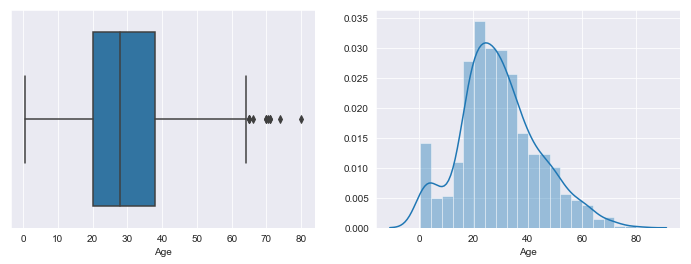

In [7]:
# stats info
print(df_EDA.Age.describe())

# shape of its distribution
f, axes = plt.subplots(1,2,figsize=(12,4))

sns.boxplot(df_EDA.Age.dropna(),ax=axes[0])
sns.distplot(df_EDA.Age.dropna(),ax=axes[1])

From the data and the graphs above, we can know that its a slightly right-skewed normal distribution. Taking the median to fill all the null value should be fine, but we want more accuracy. First, let's see what it's like to fill with median. *Wei: expectation maximization.*



In [8]:
# fill age with median, save df for comparison
test_df = df_EDA.Age.fillna(df_EDA.Age.median())

What if we look into the feature correlations and fill the median according to different situations?

In [9]:
# convert sex into categories
df_EDA['Sex_Code'] = df_EDA['Sex'].astype('category').cat.codes

# show correlation heatmaps
df_EDA.corr().style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Code
Survived,1,-0.338481,-0.0772211,-0.0353225,0.0816294,0.257307,-0.543351
Pclass,-0.338481,1,-0.369226,0.0830814,0.0184427,-0.5495,0.1319
Age,-0.0772211,-0.369226,1,-0.308247,-0.189119,0.0960667,0.0932536
SibSp,-0.0353225,0.0830814,-0.308247,1,0.414838,0.159651,-0.114631
Parch,0.0816294,0.0184427,-0.189119,0.414838,1,0.216225,-0.245489
Fare,0.257307,-0.5495,0.0960667,0.159651,0.216225,1,-0.182333
Sex_Code,-0.543351,0.1319,0.0932536,-0.114631,-0.245489,-0.182333,1


The most correlated columns for age is "Pclass", "SibSp" and "Parch". I'm going to plot and see if that's intuitively ture.

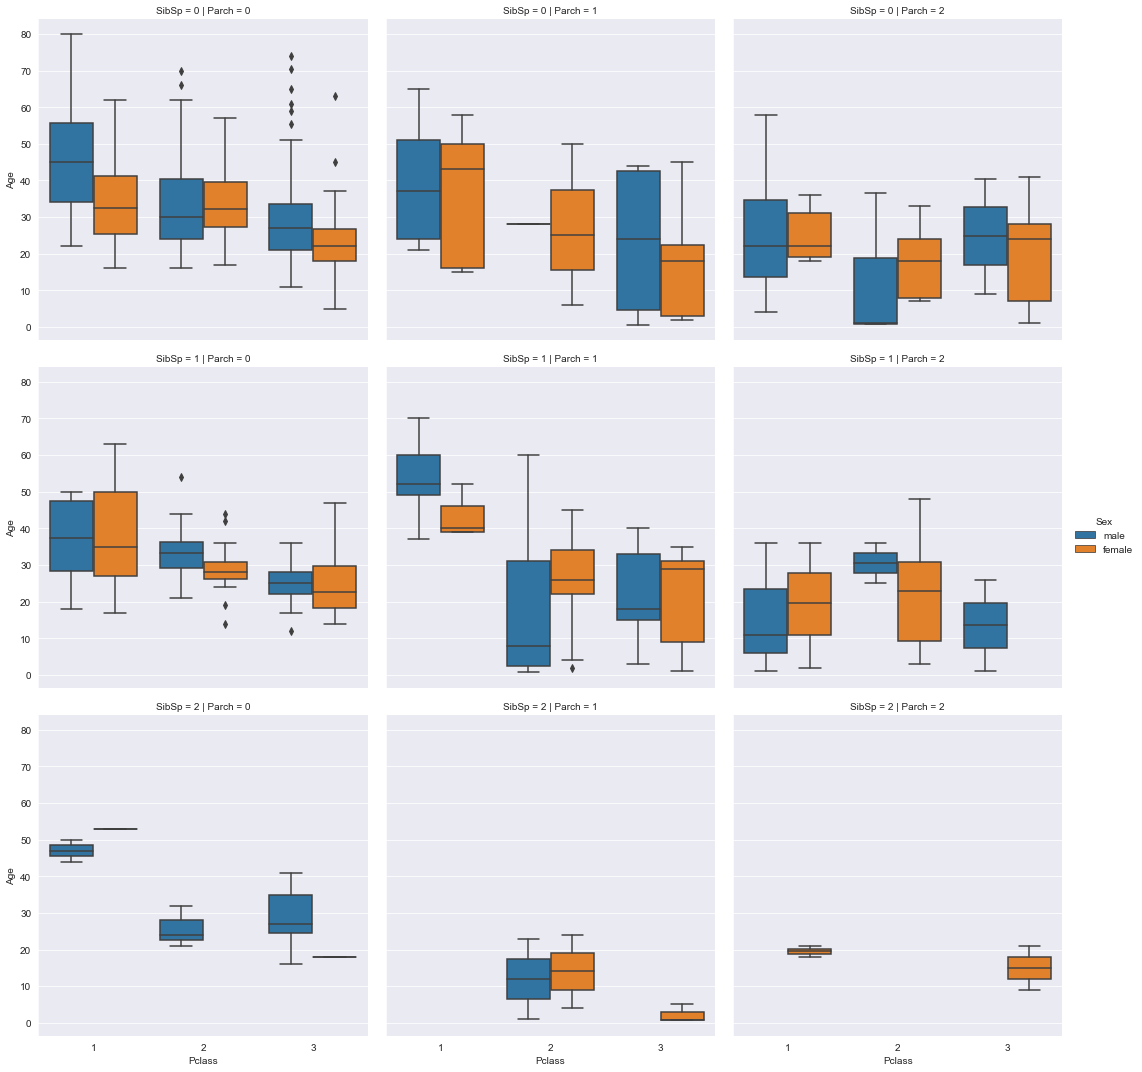

In [10]:
sns.catplot(data=df_EDA,x='Pclass', y='Age', hue='Sex',
            row='SibSp', col='Parch',kind='box',
            row_order=[0,1,2],col_order=[0,1,2])

We are gonna calculate median age for different sex, pclass, sibch and parch and fill NA with them.

count    891.000000
mean      29.387957
std       13.467945
min        0.420000
25%       22.000000
50%       27.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64 

The kurtosis of the complex method is: 0.5874999132251677
The kurtosis of the global median method is: 0.9938710163801736


Text(0,0.5,'Fill with median')

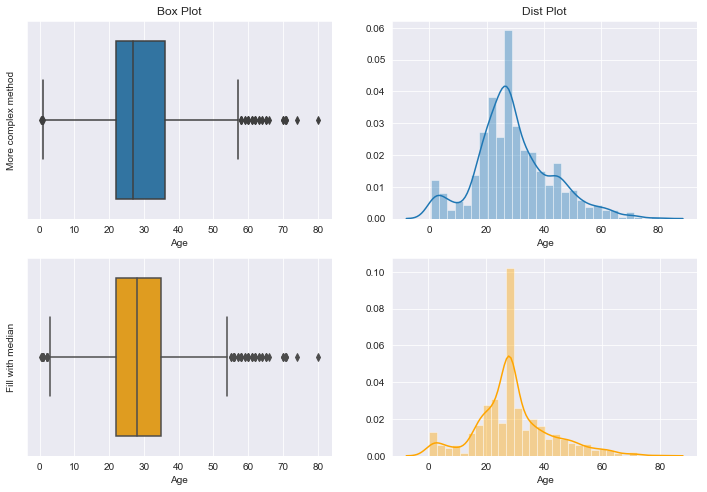

In [11]:
# Fill NA with a complex method
for ind in df_EDA[df_EDA.Age.isnull()].index:
    # filters
    filter1 = df_EDA['Sex'] == df_EDA.loc[ind, 'Sex']
    filter2 = df_EDA['Pclass'] == df_EDA.loc[ind, 'Pclass']
    filter3 = df_EDA['SibSp'] == df_EDA.loc[ind, 'SibSp']
    filter4 = df_EDA['Parch'] == df_EDA.loc[ind, 'Parch']
    fill_value = df_EDA[filter1][filter2][filter3][filter4]['Age'].median()
    
    # if filter result is nan, we fill with the global median
    if pd.isna(fill_value):
        fill_value = df_EDA['Age'].median()
    
    # fill in values
    df_EDA.loc[ind, 'Age'] = fill_value
    
# stats info
print(df_EDA.Age.describe(),"\n")

print("The kurtosis of the complex method is: {}".format(df_EDA.Age.kurtosis()))
print("The kurtosis of the global median method is: {}".format(test_df.kurtosis()))

# shape of its distribution
f, axes = plt.subplots(2,2,figsize=(12,8))

sns.boxplot(df_EDA.Age.dropna(),ax=axes[0,0])
sns.distplot(df_EDA.Age.dropna(),ax=axes[0,1])
sns.boxplot(test_df,ax=axes[1,0],color='Orange')
sns.distplot(test_df,ax=axes[1,1],color='Orange')

axes[0,0].set_title('Box Plot')
axes[0,1].set_title('Dist Plot')
axes[0,0].set_ylabel('More complex method')
axes[1,0].set_ylabel('Fill with median')

It can be clearly seen that the complex method is much better. It create less outliers, reduce the kurtosis and makes more sense intuitively.

**Cabin**

Survival Rate: 67%


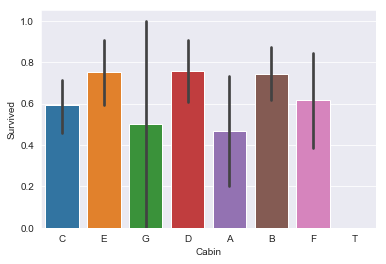

In [12]:
df_with_cabin = df_EDA[df_EDA.Cabin.notnull()]

# Let us see the survival rate
rate_of_survival_cabin = df_with_cabin.Survived.mean()
print("Survival Rate:","{:.0%}".format(rate_of_survival_cabin))

df_with_cabin['Cabin'] = df_with_cabin.Cabin.apply(lambda x: x[0])

sns.barplot(x='Cabin',y='Survived',data=df_with_cabin)

A survival rate of 66% is really high comparing to the overall rate! Remember that we have the overall survival rate of 38%. 

We already know that ticket fare and pclass are the most important factor, so I guess that only higher class people get their Cabin data recorded in the system. To prove the hypothesis, we will plot two figures with one containing all the data and another one containing only the data with Cabin info. We will see the differences in the plots below.

A little practice on the seaborn plot here =)

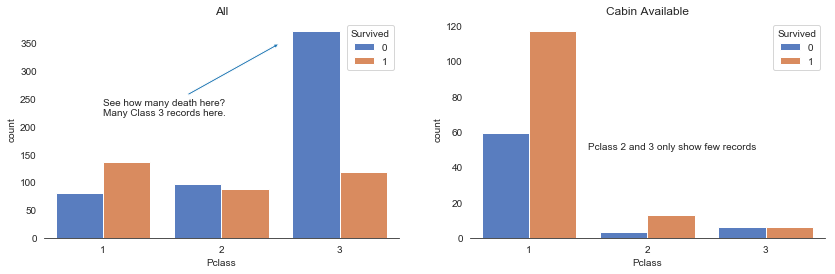

In [13]:
# style and background
# plt.style.use('seaborn-notebook')
sns.set_style("white")

# figure and sizes
f, axes = plt.subplots(1,2,figsize=(14,4))

# all data
a1 = sns.countplot('Pclass',hue='Survived',data=df_EDA,ax=axes[0],palette='muted')
# data with Cabin available
a2 = sns.countplot('Pclass',hue='Survived',data=df_with_cabin,ax=axes[1],palette='muted')

# title
a1.set_title('All')
a2.set_title('Cabin Available')

# annotation and text
a1.annotate('See how many death here?\nMany Class 3 records here.',
            (1.5,350),
            (0.0,220),
            arrowprops=dict(arrowstyle = 'simple'))
a2.text(.5,50,
        'Pclass 2 and 3 only show few records')

# style
sns.despine(left=True, bottom=False)

Hypothesis proved. I can dig deeper into it but let's now focus on the topic. This column seems to have a high correlation with the fare and pclass and it has many null values. To use that we need more digging and efforts, so we drop that.

In [14]:
df_EDA.drop(['Cabin'], axis=1, inplace=True)

# double check
df_EDA.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Sex_Code'],
      dtype='object')

**Embarked**

We got 2 missing value in the column Embarked. We fill it with the most common value in this column.

In [15]:
print('# of NA in Embarked: ',df_EDA.Embarked.isnull().sum())

df_EDA.Embarked.value_counts()

df_EDA.Embarked.fillna(df_EDA['Embarked'].mode()[0],inplace=True)

print('Are all the NAs has been filled: ', df_EDA.Embarked.notnull().all())

# of NA in Embarked:  2
Are all the NAs has been filled:  True


### Creating

1. Generate title from names.
2. Generate family size and single status from Parch and SibSp.
3. Create bins for fare and age for visualizations

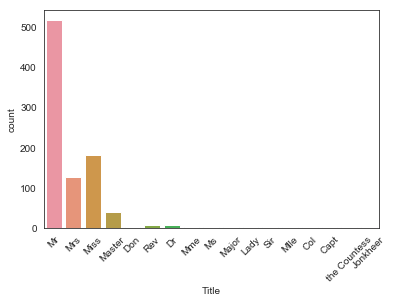

In [16]:
# split the Name column twice to get the title
df_EDA['Title'] = df_EDA.Name.apply(lambda x: x.split(', ')[1].split('. ')[0])

g = sns.countplot(df_EDA['Title'])
g = plt.setp(g.get_xticklabels(), rotation=45) 

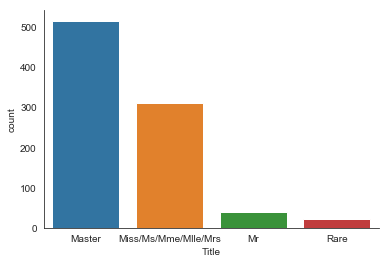

In [17]:
# Convert to categorical values Title 
df_EDA["Title"] = df_EDA["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_EDA["Title"] = df_EDA["Title"].map({"Master":"Master", "Miss":"Female", "Ms" : "Female" , "Mme":"Female", "Mlle":"Female", "Mrs":"Female", "Mr":"Male", "Rare":"Rare"})

# plot
g = sns.countplot(df_EDA["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])
sns.despine()

# create a column of family size and based on it, create another
df_EDA['FamilySize'] = df_EDA['Parch'] + df_EDA['SibSp'] + 1
df_EDA['IsAlone'] = df_EDA['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

df_EDA.head()

# create bins
df_EDA['FareBin'] = pd.qcut(df_EDA['Fare'], 4)
df_EDA['AgeBin'] = pd.cut(df_EDA['Age'].astype(int), 5)

### Converting

In [18]:
# copy it
df_for_model = df_EDA.copy()

from sklearn.preprocessing import LabelEncoder

# transform the interval/category into code, for EDA purpose
# using pandas astype category because according to Dark417, this performs better in the model
df_EDA['FareBin_Code'] = df_EDA.FareBin.astype('category').cat.codes
df_EDA['AgeBin_Code'] = df_EDA.AgeBin.astype('category').cat.codes
df_EDA['Embarked_Code'] = df_EDA['Embarked'].astype('category').cat.codes

In [19]:
# converting categorical data into one-hot columns
import patsy as pts

y, X = pts.dmatrices('Survived ~ Pclass + C(Sex) + Age + SibSp + Parch + Fare + ' +
                    'C(Embarked) + C(Title) + FamilySize + IsAlone', data=df_for_model,
                    return_type='dataframe')
pd.concat([X,y]).info()

from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 0 to 890
Data columns (total 15 columns):
Age                   891 non-null float64
C(Embarked)[T.Q]      891 non-null float64
C(Embarked)[T.S]      891 non-null float64
C(Sex)[T.male]        891 non-null float64
C(Title)[T.Male]      891 non-null float64
C(Title)[T.Master]    891 non-null float64
C(Title)[T.Rare]      891 non-null float64
FamilySize            891 non-null float64
Fare                  891 non-null float64
Intercept             891 non-null float64
IsAlone               891 non-null float64
Parch                 891 non-null float64
Pclass                891 non-null float64
SibSp                 891 non-null float64
Survived              891 non-null float64
dtypes: float64(15)
memory usage: 222.8 KB


Skewness: 4.787316519674893
kurtosis: 33.39814088089868


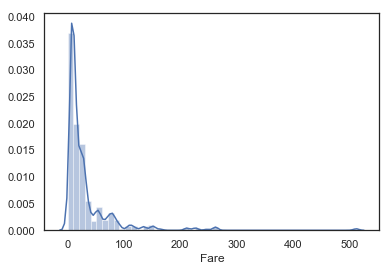

In [72]:
# Fare
sns.distplot(df_for_model.Fare)

print("Skewness: {}".format(df_for_model.Fare.skew()))
print("kurtosis: {}".format(df_for_model.Fare.kurtosis()))

Skewness: 0.44310881405404506
kurtosis: 0.641225603709215


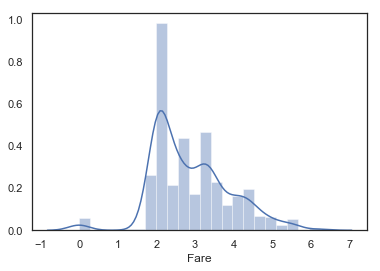

In [74]:
df_for_model['Fare'] = df_for_model.Fare.apply(lambda x: np.log(x) if x > 0 else 0)

sns.distplot(df_for_model.Fare)

print("Skewness: {}".format(df_for_model.Fare.skew()))
print("kurtosis: {}".format(df_for_model.Fare.kurtosis()))

## Exploratory Data Analysis



Take a quick look of the pairplot and see what we can get.

As pairplot will not show categorical information, we are looking at numerical data.

0    62%
1    38%
Name: Survived, dtype: object


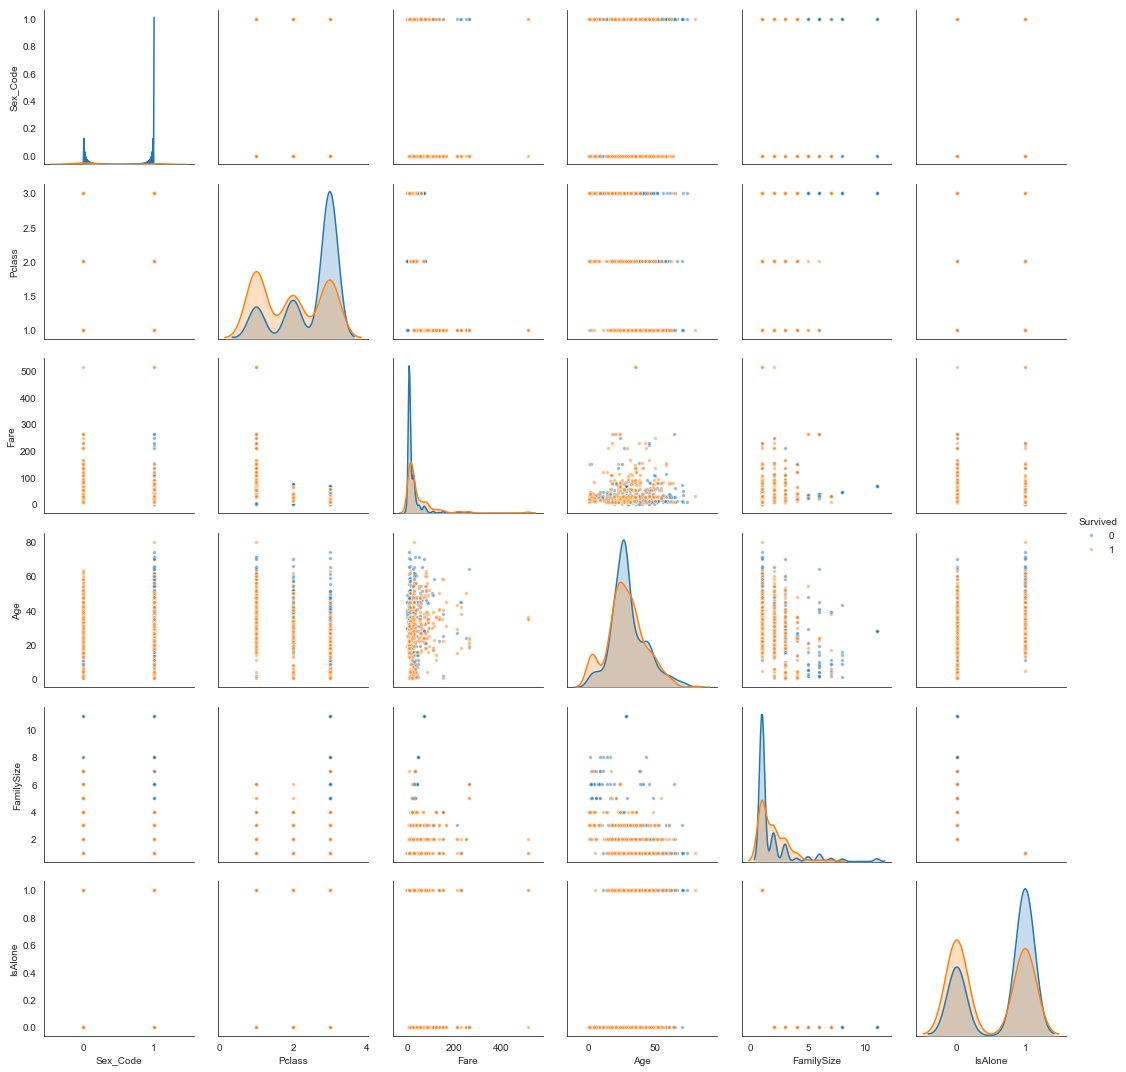

In [20]:
g = sns.pairplot(df_EDA, hue='Survived', plot_kws={'alpha':0.5,'s':13},
             vars=['Sex_Code','Pclass','Fare','Age',\
                   'FamilySize', 'IsAlone'])
# sns.catplot(kind='')

print(df_EDA.Survived.value_counts(normalize=True).apply(lambda x: '{:.0%}'.format(x)))

Diagonal:
- Fare: a clear peak along the blue line can be seen which means the fatalities are mainly distributed in the low-fare area.
- Age: Children has a higher rate to survive. Mid-age people probably sacrificed themselves?
- Sex: Apparently, women are much more likely to survive than man
- Class: Higher class passenger has a lower rate of death
- Is Alone: stick with family to gain higher survival rate
- Family Size: Don't be alone and don't take too many family friends...

Upper/lower plots:
can't see any thing.

Lastly, remember that we have 38% total survival rate.

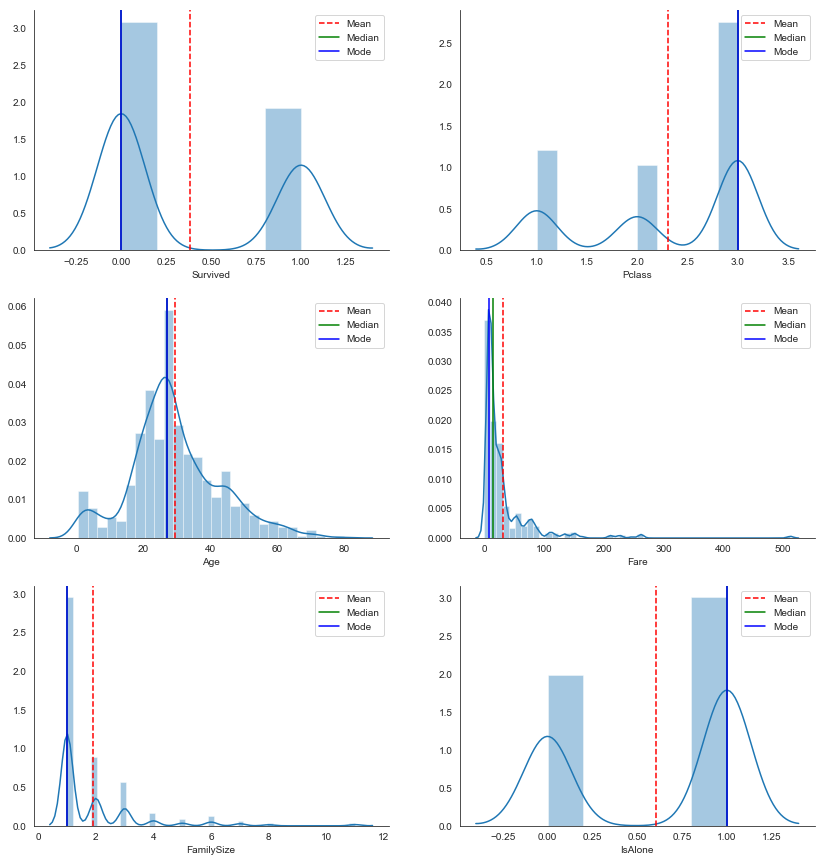

In [21]:
# I wrote a helper code to display each numeric column as a distplot.
# This is just to understand the distribution of the data.

import helper
tem_df = df_EDA.drop(['Parch', 'SibSp', 'FareBin_Code', 'AgeBin_Code', 'Title'],axis=1)
helper.distplot_w_stats(tem_df)

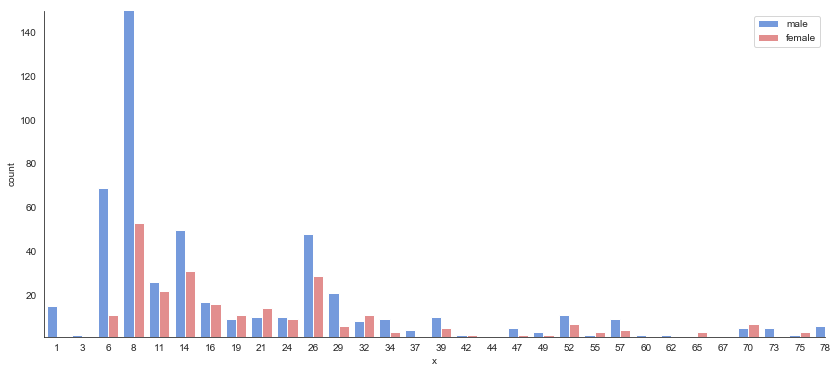

In [22]:
tem_df = pd.DataFrame()
tem_df['x'] = pd.cut(df_EDA['Fare'],200).apply(lambda x: round(int(x.mid),0))
tem_df['hue'] = df_EDA['Sex']

# plot
pal = dict(male="#6495ED", female="#F08080")

plt.subplots(figsize=(14,6))
ax = sns.countplot(x='x',hue='hue',data=tem_df,palette=pal)
plt.legend(loc=1)
ax.set_xlim([-.5,30])
ax.set_ylim([1,150])

sns.despine()

### Single and Multi Variable Analysis
#### Fare and Pclass

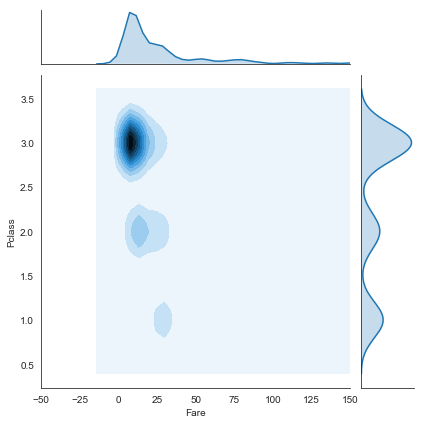

In [23]:
sns.set_style('white')

a = sns.jointplot(df_EDA['Fare'], df_EDA['Pclass'],  kind="kde", xlim=(-50,150))

sns.despine()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


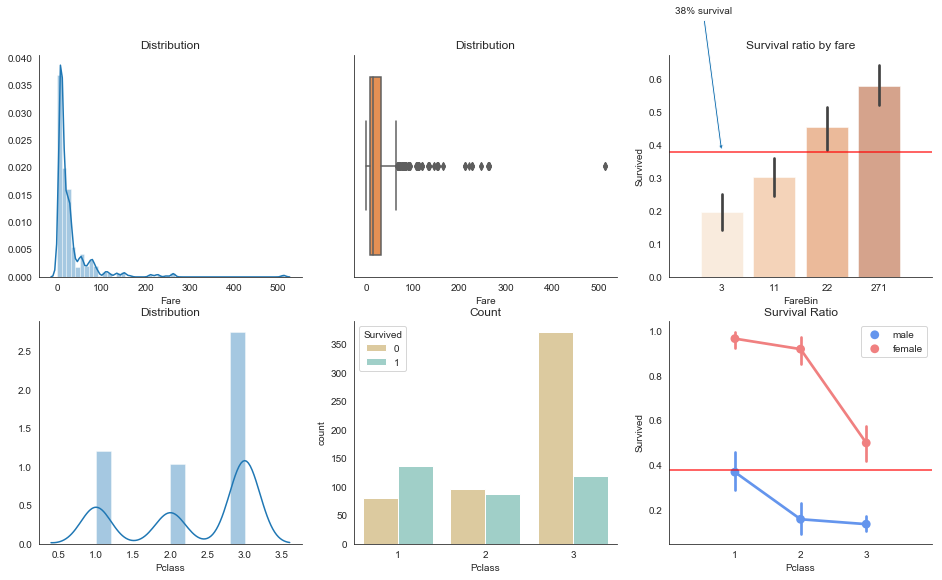

In [24]:
pal = dict(male="#6495ED", female="#F08080")

fig, a = plt.subplots(2,3,figsize=(16,9))

ax0 = sns.distplot(df_EDA.Fare, ax=a[0,0])
ax1 = sns.boxplot(df_EDA.Fare, ax=a[0,1],palette="Oranges")
ax2 = sns.barplot(df_EDA['FareBin'].apply(lambda x:int(x.mid)), df_EDA['Survived'], palette='Oranges',ax=a[0,2], alpha=0.5)
sns.lineplot([x for x in range(-1,6)], 0.38, color='red',ax=a[0,2],alpha=.8)

ax0.set_title('Distribution')
ax1.set_title('Distribution')
ax2.set_title('Survival ratio by fare')
ax2.set_xlim(-1,4)
ax2.annotate('38% survival',
            (0,.38),
            (-.9,.8),
            arrowprops=dict(arrowstyle = 'simple'))

a1 = sns.distplot(df_EDA.Pclass,ax=a[1,0])
a2 = sns.countplot('Pclass', hue='Survived', data=df_EDA, palette="BrBG",ax=a[1,1])
a3 = sns.pointplot('Pclass', 'Survived', data=df_EDA, palette=pal,hue='Sex',ax=a[1,2])
sns.lineplot([x for x in range(-1,4)], 0.38, color='red',ax=a[1,2],alpha=.8)

a1.set_title('Distribution')
a2.set_title('Count')
a3.set_title('Survival Ratio')
a3.set_xlim(-1,3)

sns.despine()
print(df_EDA.Fare.describe())

**Fare Price**
1. Distribution Plot: 

Most people paid 7.91 ~ 31.00 for the ticket, while some paid a lot of money like 512.32... We can see there are some outliers in the box plot. From the stats data showed above, we know that the mean value is influenced by the outliers, and the std is quite high possibly for the same reason. 


2. Line and Bar Plot: 

In the graph, we have 4 groups of bins, and each of them has exactly the same number as each other because we cut the fare using Quantile-based discretization function.

As expected, we found that the more money paid for the ticket, the higher survival rate it will be. 

**Pclass**
1. Most people are in class 3
2. Only class 1 has the survival rate > 50%
3. Class 3 has a low survival rate

Expected. Same reason as fare price.

**Sex**
1. Women > men.
2. Even a first class man, his survival rate < 38%.

Gentle man. My greatest respect.

#### Four Dimensional Analysis

Variables: Age, Pclass, Survived, Sex

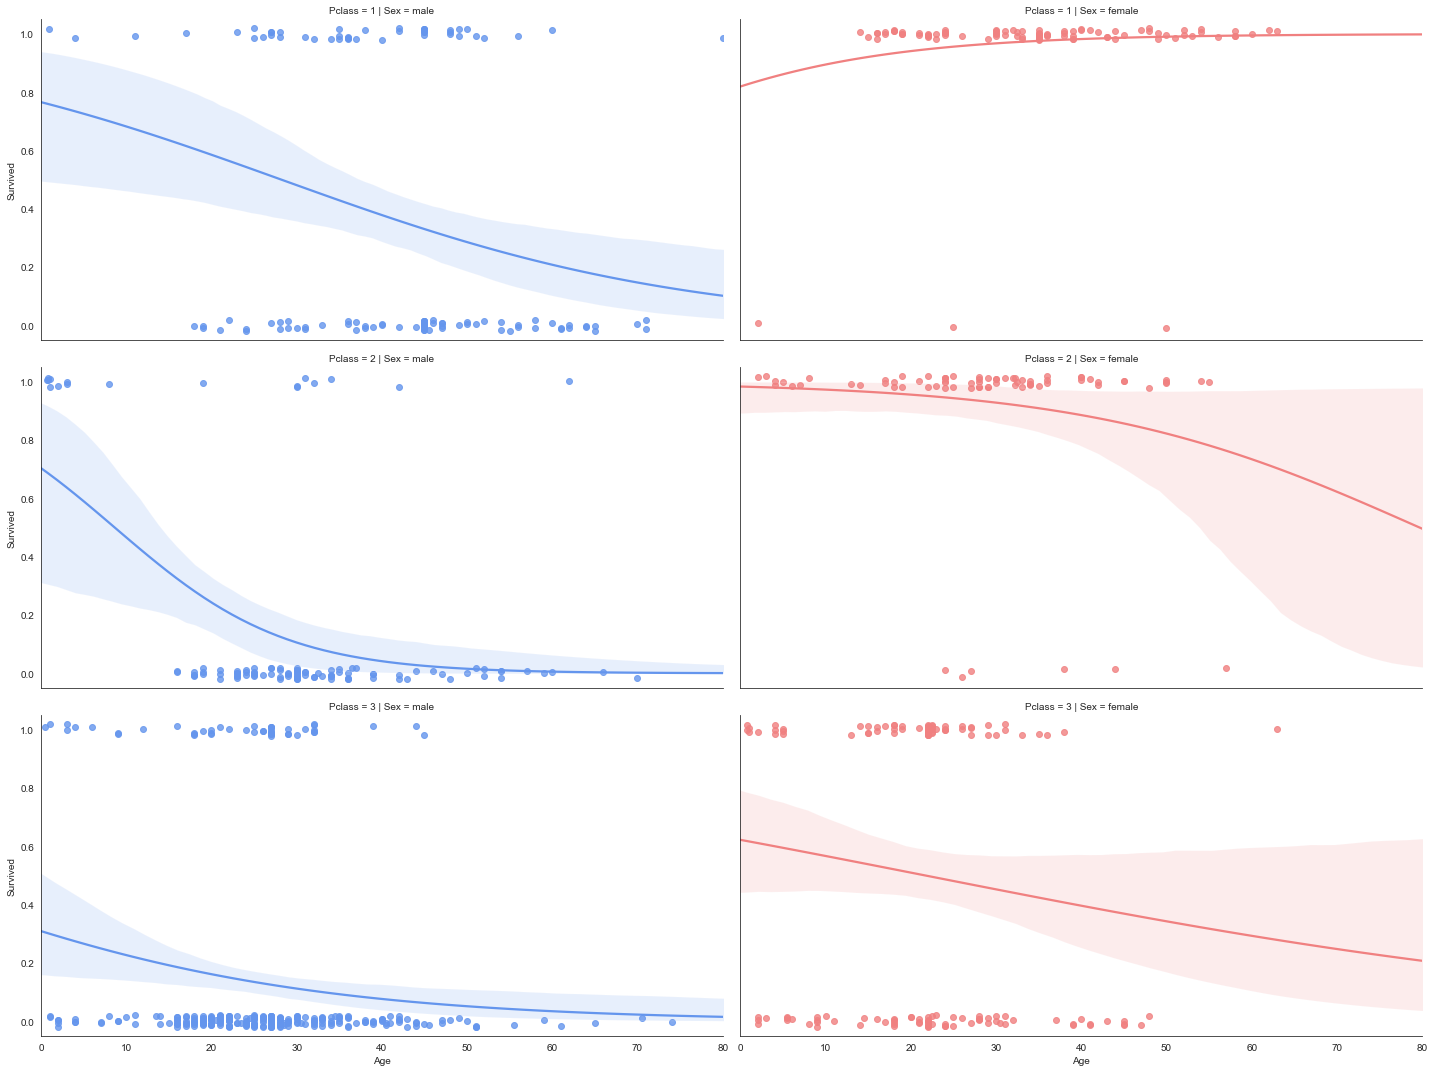

In [25]:
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="Age", y="Survived", row = 'Pclass', col="Sex", hue="Sex", data=df_EDA, aspect=2,
               palette=pal, y_jitter=.02, logistic=True)

g.set(xlim=(0, 80), ylim=(-.05, 1.05))

**Regression Plot**
- Most ladies in class one were saved, the survival rate them is extremely high
- Older ladies in class 2 have a chance to be abandoned
- Boys in Class 2 have a high rate of survival, maybe class 2 people gives their lives for the young ones.
- As the age increases, the rate of survival decreases (for most cases)
- Class 1 > class 2 > class 3, class 3 sucks
- From the left three charts, we can tell that there has a clear linear relationship between age and survived.

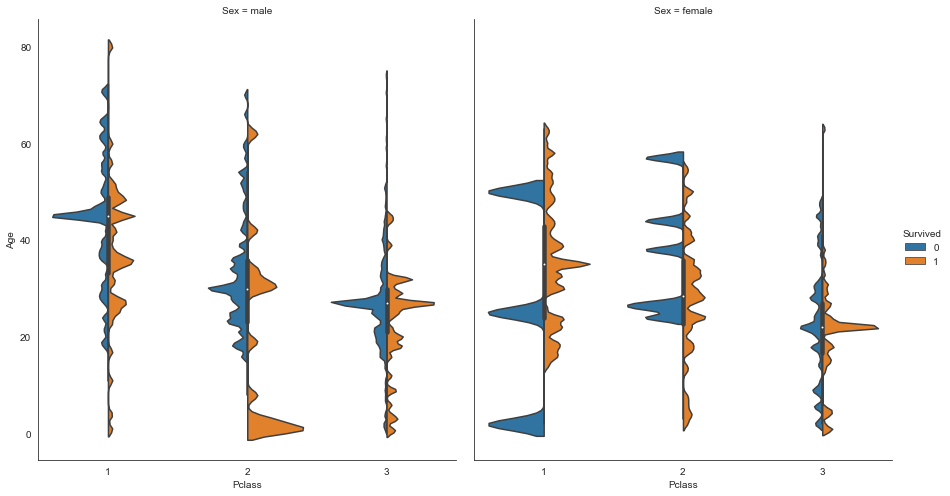

In [26]:
g = sns.factorplot(x="Pclass", y="Age", hue="Survived", col="Sex",
                   data=df_EDA, kind="violin", split=True,
                   bw=0.05, size=7, aspect=.9, s=7)

**Violin plots**

This is another way to display a 4 dimensional chart. While the lmplots emphases on the relationships between x and y, violin plots focuses on showing the distribution of the survivors.

- Class 2 boys are all saved! 
- A peak in female class 3: it shows that most of the ladies on in this age.
- Some peaks can be misleading because of lack of data... e.g. female, pclass 1 and 2, not survived. However, if you know the dataset well enough, you will know there are a few females unfortunately die in this event from class 1 and 2 and these peaks demonstrate that.
- From the tail/head of the distribution, we can see that there are more old men than old women

#### Ticket

This is a tricky one and I don't wanna go too deep on that, but let's try it anyway. From the numbers, we can know the sequence of booking and something more, but I really don't think this will contribute much on the analysis. 

Instead, let's see what's the survival rate for different strings included in the ticket.

In [27]:
# replacing all digit with empty strings, and show the result
def replace_digit(x):
    result = ""
    for i in x:
        if not i.isdigit():
            result = "".join([result,i])
    return result.strip()

# save the result in a variable
converted_ticket = train_df['Ticket'].apply(replace_digit)

# create a slicer including top 5 values of the above variable
slicer = train_df['Ticket'].apply(replace_digit).value_counts().index[:5]

Testing for 
Number of data: 661
P(Survival) = 38%
--------------------
Testing for PC
Number of data: 60
P(Survival) = 65%
--------------------
Testing for C.A.
Number of data: 27
P(Survival) = 48%
--------------------
Testing for A/
Number of data: 13
P(Survival) = 8%
--------------------
Testing for STON/O .
Number of data: 12
P(Survival) = 42%
--------------------


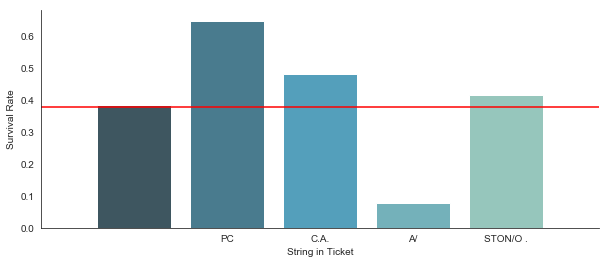

In [28]:
j = []
k = []

for i in slicer:
    print('Testing for {}'.format(i))
    print('Number of data: {}'.format(sum(converted_ticket == i)))
    j.append(i)
    try:
        survival_rate = train_df[converted_ticket == i].Survived.value_counts(normalize=True).loc[1]
        print('P(Survival) = {:.0%}'.format(survival_rate))
        k.append(survival_rate)
        
    except:
        print('The rate of survival is 0')
        k.append(0)
        
    print('-'*20)

f, axis = plt.subplots(figsize=(10,4))
a1 = sns.barplot(j,k,palette='GnBu_d')
sns.lineplot(range(-1,len(j) + 1),[.38 for j in range(len(j) + 2)],color='red')
a1.set_xlabel('String in Ticket')
a1.set_ylabel('Survival Rate')
a1.set_xlim(-1,5)

sns.despine()

As we already know that the rate of survival for the entire training set is 38%, the first result proves that again. The second result shows a **65% of survival rate**. Is that merely a coincidence? Does PC stands for premium class? We should see correlations between different columns later.

The rest of the results cannot prove anything due to lack of data.

In [29]:
# we convert the ticket to another column
# will use it later
converted_ticket = converted_ticket.apply(lambda x: 1 if x == 'PC ' else 0)

#### Cabin

In [30]:
Cabin_transformed = train_df.Cabin.apply(lambda x: replace_digit(str(x)))
Cabin_counts = train_df.Cabin.apply(lambda x: replace_digit(str(x))).value_counts()
Cabin_filter = Cabin_counts > 10

Cabin_transformed = Cabin_transformed.fillna('nan').apply(lambda x: x if Cabin_filter[x] else 'misc')

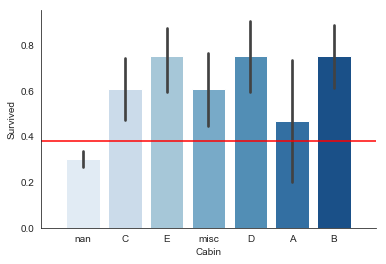

In [31]:
a = sns.barplot(Cabin_transformed,train_df.Survived, palette='Blues')
sns.lineplot(range(-1,8),[.38 for x in range(9)],color='red')

a.set_xlim(-1,7)
sns.despine()

Remember, we only have 200+ number of data in Cabin, which only takes 25% of the total.

Very interestingly, We can see the survival rates for Cabin with letters in them all exceed the overall fatality rate. The rest of records that have no Cabin data with them have a lower than overall survival rate - 30%.

#### Embarked

***********************************
Survival Rate wrt Embarked
Embarked         C        Q         S
Survived  0.553571  0.38961  0.339009
***********************************
***********************************
Embarked Count
S    646
C    168
Q     77
Name: Embarked, dtype: int64
***********************************


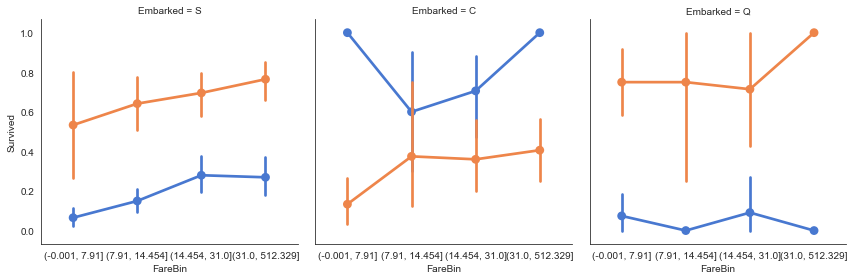

In [32]:
print('*'*35)
print('Survival Rate wrt Embarked')
print(df_EDA.pivot_table(values='Survived',columns=['Embarked']))
print('*'*35)

print('*'*35)
print('Embarked Count')
print(df_EDA.Embarked.value_counts())
print('*'*35)
g = sns.FacetGrid(df_EDA, col = 'Embarked', height =4)
g.map(sns.pointplot,'FareBin', 'Survived', 'Sex', palette='muted')

sns.despine()

- People embarked at C has a higher rate of survival. Maybe they have higher class ticket?
- Men's survival rate is higher than women in C.

### Correlations between data

- Chart 1: Feature Correlation w.r.t. Survival
- Chart 2: Correlations between all features

In [33]:
corr_data = (df_EDA.corr()
 .drop(['Survived'])['Survived']
 .apply(abs)
 .sort_values(ascending=True)
)

(corr_data
 .apply(lambda x: '{:.2%}'.format(x))
 .to_frame('Correlation with Survival')
)

,Correlation with Survival
FamilySize,1.66%
AgeBin_Code,3.49%
SibSp,3.53%
Age,6.52%
Parch,8.16%
Embarked_Code,16.77%
IsAlone,20.34%
Fare,25.73%
FareBin_Code,29.94%
Pclass,33.85%


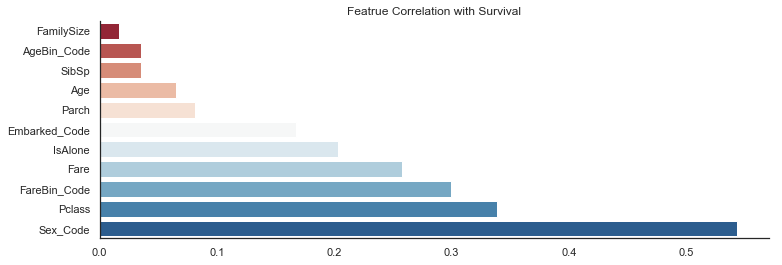

In [34]:
sns.set(style = 'white')
plt.subplots(figsize=(12,4))

ax = sns.barplot(corr_data.values,
                 corr_data.index,
                 orient='h',
                 palette='RdBu')

ax.set_title('Featrue Correlation with Survival')

sns.despine()

- Sex has the largest correlation value with survival. We've seen the difference in EDA. Expected.
- Ticket class and Fare follows. We have fare, fare bins and pclass, and all of them are social class indicators. We should the correlations between these three features.
- Is alone: this is a great column created from Parch + SibSp. Nice job.
- Embarked: we've know that people embarked at C have greater chance to survive.

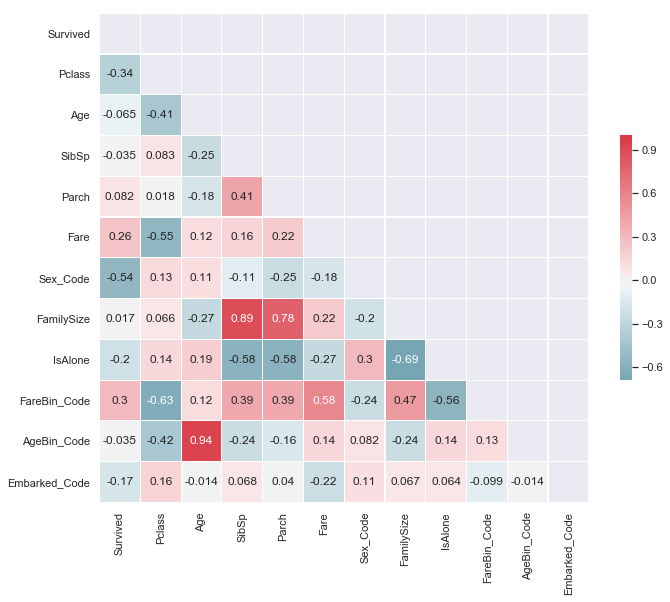

In [35]:
sns.set(style = 'darkgrid')

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(df_EDA.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(df_EDA.corr(), 
            center=0, 
            cmap = cmap,
            square=True,
            ax=ax,
            mask = mask,
            annot=True, 
            linewidths=0.1,
            linecolor='white',
            annot_kws={'fontsize':12},
            cbar_kws={"shrink": .5})

- Family size is high correlated with SibSp and Parch. So as IsAlone.
- Age and title is correlated... Interesting
- Fare and isalone is negatively correlated... 

## Model

### Model Selection

In [36]:
X_train.columns

Index(['Intercept', 'C(Sex)[T.male]', 'C(Embarked)[T.Q]', 'C(Embarked)[T.S]',
       'C(Title)[T.Male]', 'C(Title)[T.Master]', 'C(Title)[T.Rare]', 'Pclass',
       'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone'],
      dtype='object')

In [50]:
# clean names
for i in [X_train,X_test]:
    i.columns = ['Intercept', 'C(Sex)T.male', 'C(Embarked)T.Q', 'C(Embarked)T.S',
           'C(Title)T.Male', 'C(Title)T.Master', 'C(Title)T.Rare',
           'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
           'FamilySize', 'IsAlone']

                        Score      Time
XGB                    83.80%  0.094944
Discriminant Analysis  82.12%  0.015626
GradientBoosting       81.56%  0.174474
LogisticRegression     81.56%  0.312518
BernoulliNB            80.45%  0.000000
Perception             75.42%  0.015625
GaussianNB             74.86%  0.000000
Decision Tree          74.86%  0.000000
Random Rorest          73.74%  0.031254
KNN                    73.18%  0.000000
SVM                    68.16%  0.110766
SGD                    63.13%  0.000000


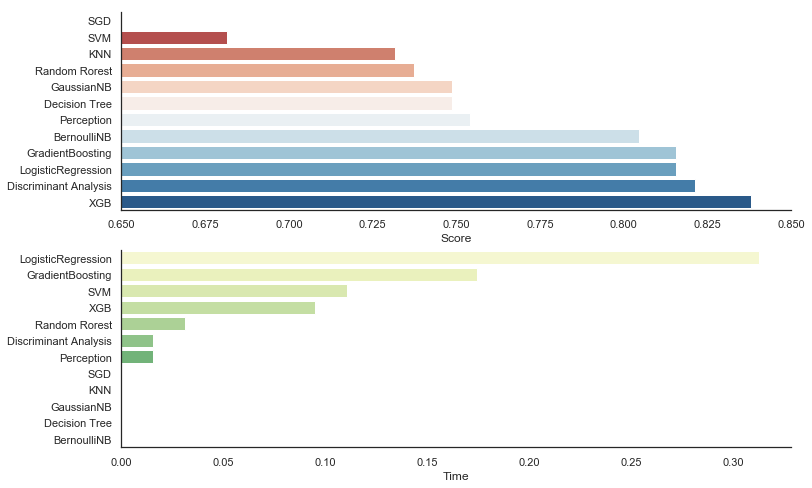

In [100]:
from xgboost import XGBClassifier
from sklearn import ensemble, linear_model, svm, naive_bayes, discriminant_analysis, neighbors, tree
from sklearn.preprocessing import normalize
import time

# models
classifers = {'Random Rorest': ensemble.RandomForestClassifier(), # Ensembling Method
              'GradientBoosting': ensemble.GradientBoostingClassifier(),
              'XGB': XGBClassifier(),
              # Linear model
              'LogisticRegression': linear_model.LogisticRegressionCV(),
              'SGD': linear_model.SGDClassifier(),
              'Perception': linear_model.Perceptron(), 
              # Naive bayes
              'BernoulliNB': naive_bayes.BernoulliNB(),
              'GaussianNB': naive_bayes.GaussianNB(),
              'SVM': svm.SVC(probability=True),
              # neighboors
              'KNN': neighbors.KNeighborsClassifier(),
              # Trees
              'Decision Tree': tree.DecisionTreeClassifier(),
              'Discriminant Analysis': discriminant_analysis.LinearDiscriminantAnalysis()}

# create a loop for models to fit and generate scores
classifier_name = []
classifier_score = []
classifier_time = []

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

for C in classifers:
    start = time.time() # time start
    classifier = classifers[C] #initializing
    classifier.fit(X_train_norm,y_train) #fitting
    score=classifier.score(X_test_norm,y_test) #scoring
    end = time.time() # time end
    
    timespent = end - start
    
    classifier_name.append(C)
    classifier_score.append(score)
    classifier_time.append(timespent)

number_of_C = len(classifers.keys())
# transform the lists to dataframes (this is not necessary)
temp = np.hstack((np.array(classifier_score).reshape(number_of_C,1),
                  np.array(classifier_time).reshape(number_of_C,1)))



score_plot = pd.DataFrame(index=classifier_name,data=temp,columns=['Score','Time']).sort_values('Score',ascending=True)

tem_df = score_plot.copy()

tem_df['Score'] = (tem_df
      .loc[:,['Score']]
      .apply(lambda x: "{:.2%}".format(x[0]),axis=1))
print(tem_df.sort_values('Score',ascending=False))

# Barplot for scores and times
sns.set(style = 'white')
f, axes = plt.subplots(2,1,figsize=(12,8))

ax1 = sns.barplot(score_plot['Score'], 
                  score_plot.index,palette='RdBu',
                  ax=axes[0])

ax1.set_xlim(.65,.85)

score_plot.sort_values('Time',ascending=False,inplace=True)
ax2 = sns.barplot(score_plot['Time'], 
                  score_plot.index,
                  palette='YlGn',
                  ax=axes[1])

sns.despine()

**Accuracy**
All models were using the default method to learn, so the accuracy is not maximized.

Discriminant Analysis > Logistic Regression > GB > Bayes > XGB > Random Forest > KNN > Decision Tree

**How about normalization?**

We used a normalization process in the last cell. Now, we are going to model it without norming the data and see what we have.

                        Score      Time
GradientBoosting       83.80%  0.126314
XGB                    83.80%  0.093756
LogisticRegression     82.68%  0.591765
Discriminant Analysis  82.68%  0.000000
Random Rorest          82.12%  0.031251
GaussianNB             81.56%  0.000000
BernoulliNB            80.45%  0.000000
Decision Tree          79.33%  0.015629
Perception             78.77%  0.000000
SGD                    75.98%  0.000000
SVM                    74.30%  0.141771
KNN                    73.18%  0.000000


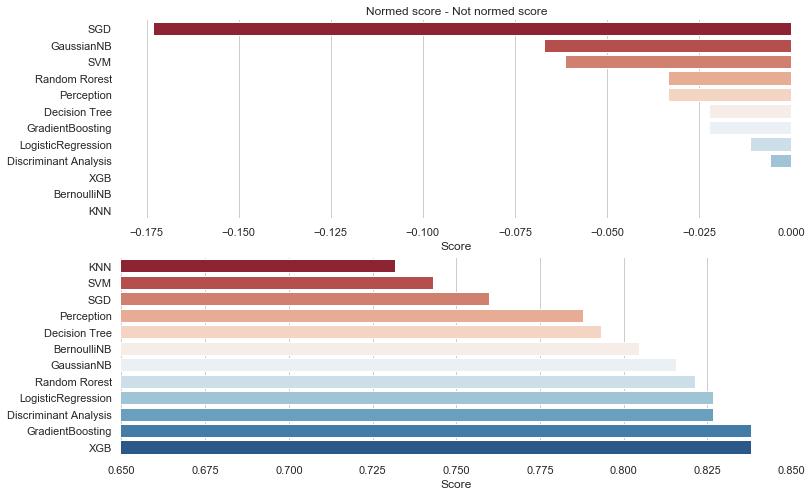

In [99]:
# models
classifers = {'Random Rorest': ensemble.RandomForestClassifier(), # Ensembling Method
              'GradientBoosting': ensemble.GradientBoostingClassifier(),
              'XGB': XGBClassifier(),
              # Linear model
              'LogisticRegression': linear_model.LogisticRegressionCV(),
              'SGD': linear_model.SGDClassifier(),
              'Perception': linear_model.Perceptron(), 
              # Naive bayes
              'BernoulliNB': naive_bayes.BernoulliNB(),
              'GaussianNB': naive_bayes.GaussianNB(),
              'SVM': svm.SVC(probability=True),
              # neighboors
              'KNN': neighbors.KNeighborsClassifier(),
              # Trees
              'Decision Tree': tree.DecisionTreeClassifier(),
              'Discriminant Analysis': discriminant_analysis.LinearDiscriminantAnalysis()}

# create a loop for models to fit and generate scores
classifier_name1 = []
classifier_score1 = []
classifier_time1 = []

for C in classifers:
    start = time.time() # time start
    classifier = classifers[C] #initializing
    classifier.fit(X_train,y_train) #fitting
    score=classifier.score(X_test,y_test) #scoring
    end = time.time() # time end
    
    timespent = end - start
    
    classifier_name1.append(C)
    classifier_score1.append(score)
    classifier_time1.append(timespent)

number_of_C = len(classifers.keys())
# transform the lists to dataframes (this is not necessary)
temp1 = np.hstack((np.array(classifier_score1).reshape(number_of_C,1),
                  np.array(classifier_time1).reshape(number_of_C,1)))

score_diff = (pd.DataFrame(index=classifier_name1,data= temp - temp1 ,columns=['Score','Time'])
              .sort_values('Score',ascending=True))
score_plot = (pd.DataFrame(index=classifier_name1,data= temp1 ,columns=['Score','Time'])
              .sort_values('Score',ascending=True))

tem_df = score_plot.copy()

tem_df['Score'] = (tem_df
      .loc[:,['Score']]
      .apply(lambda x: "{:.2%}".format(x[0]),axis=1))
print(tem_df.sort_values('Score',ascending=False))

# Barplot for scores and times
sns.set_style('whitegrid')
f, axes = plt.subplots(2,1,figsize=(12,8))

ax1 = sns.barplot(score_diff['Score'], 
                  score_diff.index,palette='RdBu',
                  ax=axes[0]
                  )
ax1.set_title('Normed score - Not normed score')

ax2 = sns.barplot(score_plot['Score'], 
                  score_plot.index,palette='RdBu',
                  ax=axes[1])
ax2.set_xlim(.65,.85)

sns.despine(left=True,bottom=True)

I am so confused. Why modeling on normalized dataset returns a lower score? But look at that SGD model, normalization increase its accuracy by over 10%! KNN got a 5% boost in the normed data. Interesting.

**Support from Wei:** *SVM, Random forest and XGB might not be sensitive to feature normalize. That's because they don't have the process of "weights x features". SGD is based on some random selections, so it is not stable especially in this small dataset. As to why the result turns out that way, there might be two answers:*
1. *The model is not a good selection for this problem*
2. *Errors in the training process*

### Tuning

In this section, I will only tune features for the algorithms that perform great in the last section, which are:

- Discriminant Analysis
- Logistic Regression
- Gradient Boosting
- Bernoulli Naive Bayes
- Extreme Gradient Boosting

#### Feature Importance, Precision and Recall



In [52]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_FI(clf, model, model_name):
    '''
    clf for classifier
    model:
    1. linear
    2. tree
    '''
    # model
    clf = clf
    clf.fit(X_train, y_train)
    
    # preparing feature importance score
    empty_df = X_train.copy().drop(X_train.index)
    
    if model == 'tree':
        empty_df.loc[0,] = clf.feature_importances_
    elif model == 'linear':
        empty_df.loc[0,] = abs(clf.coef_)
        total = empty_df.loc[0,].sum()
        empty_df = empty_df.apply(lambda x:x/total)

    plot_df = empty_df.transpose().sort_values(0,ascending=False)
    plot_df.columns = [model_name]
    
    # ploting feature importance
    plt.subplots(figsize=(14,4))
    sns.barplot(plot_df[model_name],plot_df.index)

    pred = clf.predict(X_test)
    print("The overall score is: {:.2%}\n".format(clf.score(X_test,y_test)))
    print(classification_report(y_test,pred))
    
    
    # Precision and recall
    def inverse_of_oneandzero(x):
        if x == 1:
            return 0
        elif x == 0:
            return 1
        else:
            return np.nan
        
    result = pred.reshape(pred.shape[0],1) == y_test
    tp_1 = result[y_test == 1]
    fn_1 = result[y_test == 1]['Survived'].apply(inverse_of_oneandzero).to_frame()
    tn_1 = result[y_test == 0]
    fp_1 = result[y_test == 0]['Survived'].apply(inverse_of_oneandzero).to_frame()

    tp_0 = result[y_test == 0]
    fn_0 = result[y_test == 0]['Survived'].apply(inverse_of_oneandzero).to_frame()
    tn_0 = result[y_test == 1]
    fp_0 = result[y_test == 1]['Survived'].apply(inverse_of_oneandzero).to_frame()
    
    precision_1 = tp_1.sum() / (tp_1.sum() + fp_1.sum())
    precision_0 = tp_0.sum() / (tp_0.sum() + fp_0.sum())
    recall_1 = tp_1.sum() / (tp_1.sum() + fn_1.sum())
    recall_0 = tp_0.sum() / (tp_0.sum() + fn_0.sum())
    
    return plot_df, [precision_0[0], precision_1[0], recall_0[0], recall_1[0]]

The overall score is: 83.80%

             precision    recall  f1-score   support

        0.0       0.85      0.89      0.87       105
        1.0       0.83      0.77      0.80        74

avg / total       0.84      0.84      0.84       179



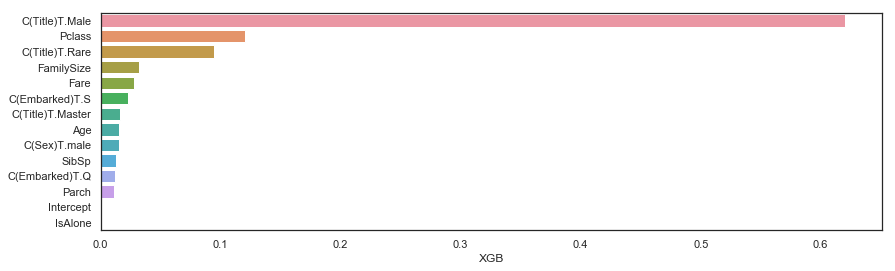

In [53]:
# XGB
clf = XGBClassifier()
XGB_df, XGB_pr = plot_FI(clf,'tree','XGB')

Seeing the plot, I don't think this algorithm performs well because it shows high importance on Sex and very low importance for others.

The overall score is: 83.80%

             precision    recall  f1-score   support

        0.0       0.84      0.90      0.87       105
        1.0       0.84      0.76      0.79        74

avg / total       0.84      0.84      0.84       179



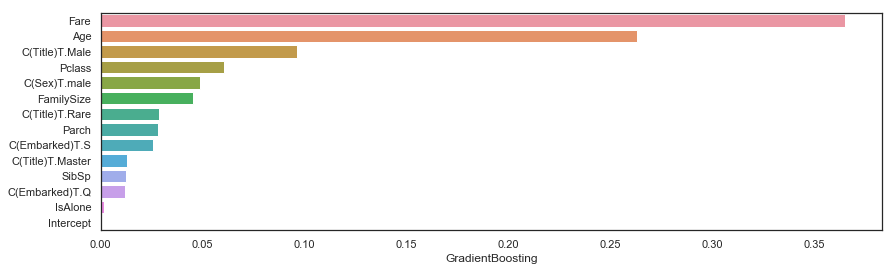

In [54]:
# gradient boosting
clf = ensemble.GradientBoostingClassifier()
GB_df, GB_pr = plot_FI(clf,'tree','GradientBoosting')

Different focuses than the XGB.

The overall score is: 83.24%

             precision    recall  f1-score   support

        0.0       0.86      0.85      0.86       105
        1.0       0.79      0.81      0.80        74

avg / total       0.83      0.83      0.83       179



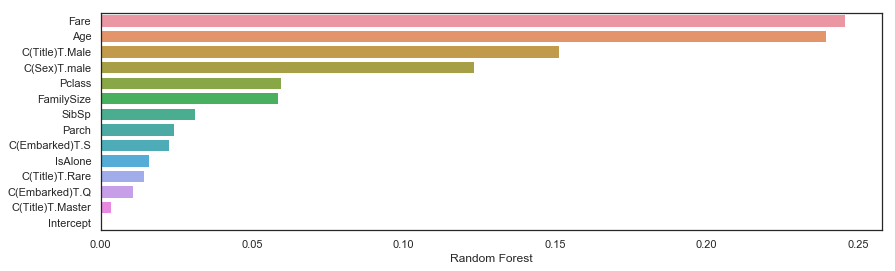

In [55]:
# Random Forest
clf = ensemble.RandomForestClassifier()
RF_df, RF_pr = plot_FI(clf,'tree','Random Forest')

I like this! It finally takes Fare and Age into consideration! However, the result is lower than the above. Terrible prediction on those survived. This algorithm sacrifices recall score on survived to get a high overall result. That's not cool.

Maybe, it is all about sex? WTF!

The overall score is: 82.68%

             precision    recall  f1-score   support

        0.0       0.85      0.86      0.85       105
        1.0       0.79      0.78      0.79        74

avg / total       0.83      0.83      0.83       179



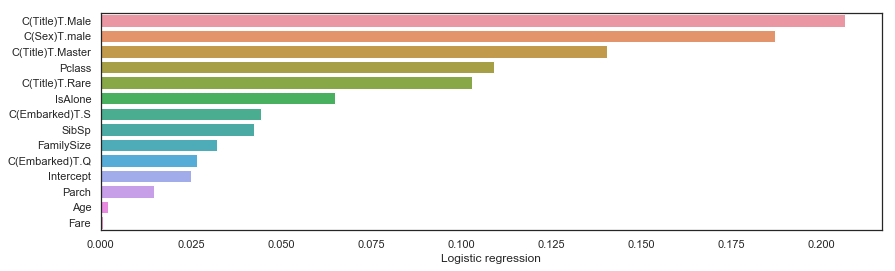

In [56]:
# logistic regression
clf = linear_model.LogisticRegressionCV()
logistic_df, logistic_pr = plot_FI(clf,'linear', 'Logistic regression')

Finally, we have something good!
- We need to dig deepter into the Misc type of the title! See the high coefficient~ That's the key.
- Sex is still important. We need to drop some columns like "Miss" and "Mr" because we already have male and female.
- Intercept? Do we even need to have that?
- Age... Why age is not considered at all? And the fare... Interesting.

The overall score is: 80.45%

             precision    recall  f1-score   support

        0.0       0.84      0.82      0.83       105
        1.0       0.75      0.78      0.77        74

avg / total       0.81      0.80      0.80       179



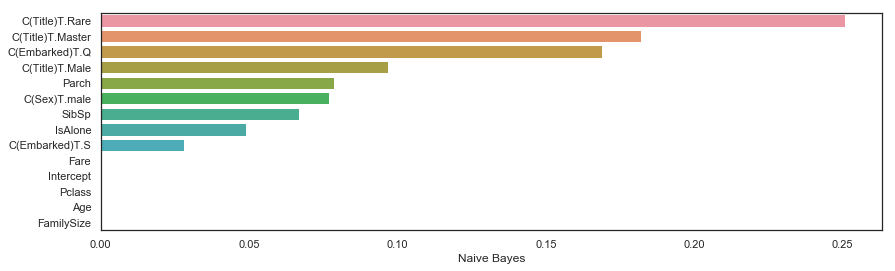

In [57]:
# Naive Bayes
clf = naive_bayes.BernoulliNB()
NB_df, NB_pr = plot_FI(clf,'linear', 'Naive Bayes')

Very interestingly, fare and age, the most important features, was considered irrelevant to NB's model. However, it did come up with a generally great score.

In [62]:
from IPython.display import HTML

feature_importance_df = pd.concat([XGB_df, GB_df, RF_df, logistic_df, NB_df],axis=1)

for col in feature_importance_df.columns:
    feature_importance_df[col] = feature_importance_df[col].apply(lambda x: round(x,4))

feature_importance_df['Total'] = feature_importance_df.apply(lambda x: round(sum(x),4),axis=1)
feature_importance_df.sort_values('Total',ascending=False,inplace=True)
feature_importance_df.drop('Total',axis=1).style.background_gradient()

,XGB,GradientBoosting,Random Forest,Logistic regression,Naive Bayes
C(Title)T.Male,0.62,0.0963,0.1513,0.2064,0.0967
Fare,0.0277,0.365,0.2456,0.0006,0.0005
Age,0.0156,0.2631,0.2394,0.0021,0.0003
C(Title)T.Rare,0.0943,0.0284,0.0143,0.1032,0.2508
C(Sex)T.male,0.0154,0.0487,0.1231,0.1871,0.077
C(Title)T.Master,0.016,0.0129,0.0033,0.1404,0.1822
Pclass,0.1199,0.0604,0.0597,0.1093,0.0003
C(Embarked)T.Q,0.0123,0.0117,0.0107,0.0267,0.1691
FamilySize,0.032,0.0455,0.0585,0.0323,0.0003
SibSp,0.0132,0.0123,0.0313,0.0425,0.0668


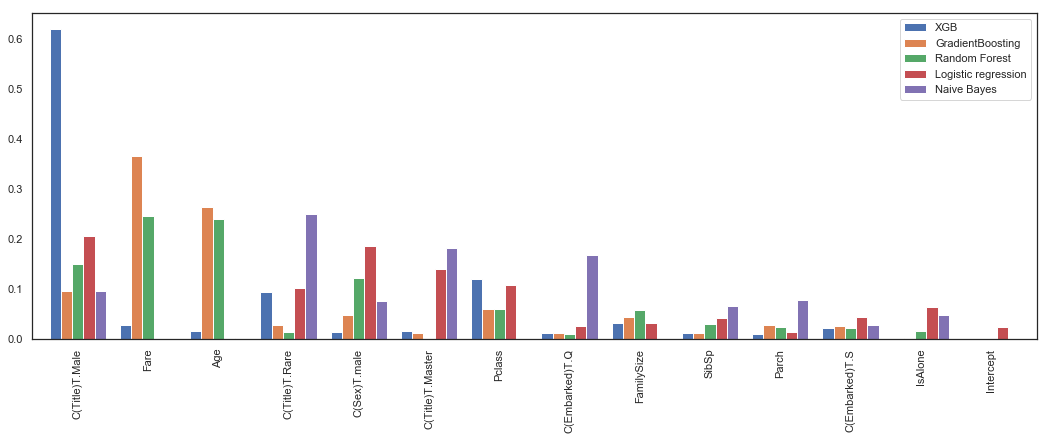

In [59]:
feature_importance_df.drop('Total',axis=1).plot(kind='bar', figsize=(18,6),width=.8)

In [60]:
pr_dic = {'XGB_pr': XGB_pr,
          'GB_pr': GB_pr,
          'RF_pr': RF_pr,
          'logistic_pr': logistic_pr,
          'NB_pr': NB_pr}

precision_recall_df = pd.DataFrame(columns=['precision_0','precision_1','recall_0','recall_1'])

for key in pr_dic:
    precision_recall_df.loc[key,:] = pr_dic[key]

            precision_0 precision_1  recall_0  recall_1
RF_pr          0.864078    0.789474  0.847619  0.810811
logistic_pr    0.849057    0.794521  0.857143  0.783784
NB_pr          0.843137    0.753247  0.819048  0.783784
XGB_pr         0.845455    0.826087  0.885714   0.77027
GB_pr          0.839286    0.835821  0.895238  0.756757


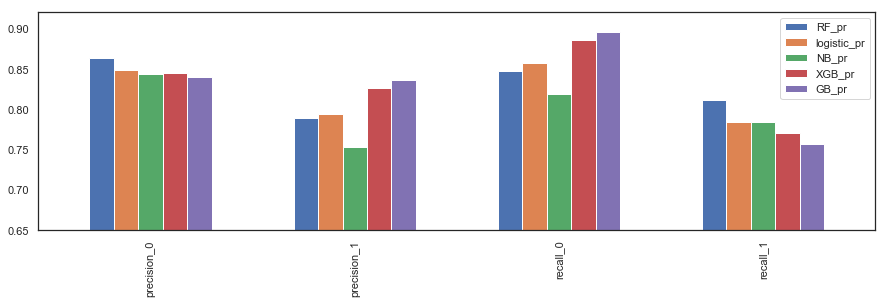

In [61]:
precision_recall_df.sort_values('recall_1',ascending=False,inplace=True)
print(precision_recall_df)
precision_recall_df.transpose().plot(kind='bar',ylim=[0.65,0.92],figsize=(15,4),width=.6)

**SUMMARY**

Different focuses among models
- XGB: XGB is sexist! In its algorithm, sex takes almost 70% of the weight when computing the result.
- GB and RF: They really love continous data like Fare and Age.
- LR and NB: A wide interests across the data, especially in categorical or discrete data. What happens to Fare and Age??? haha

Features
- T1: Sex, fare, age, social class
- T2: Embarked, Parch, SibSp,
- T9: IsAlone... No model needs this!

Precision and Recall

- The recall score for survived data is the lowest, that's what we should focus on. Logistic regression has achieved the best score on it.

TODO:
- K fold cross validation
- Tuning